In [71]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

###

from lazypredict.Supervised import LazyRegressor
import lazypredict.Supervised

import sklearn
import xgboost
import lightgbm

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error



In [75]:
df = pd.read_csv('UCI_datasets/CNNpred/Processed_NYSE.csv')

In [45]:
#drop rows with nan
#drop cols with nan
#encode dates in cos/sin
#encode hour in cos sin
df.shape

(1984, 84)

In [37]:
df.isna().sum().tail(50) > 50

WFC               False
XOM               False
FCHI              False
FTSE               True
GDAXI              True
DJI               False
HSI                True
IXIC              False
SSEC               True
S&P               False
RUT               False
TE1               False
TE2               False
TE3               False
TE5               False
TE6               False
DE1               False
DE2               False
DE4               False
DE5               False
DE6               False
CTB3M             False
CTB6M             False
CTB1Y             False
Name              False
AUD               False
Brent             False
CAC-F             False
copper-F          False
WIT-oil           False
DAX-F             False
DJI-F             False
EUR               False
FTSE-F            False
gold-F            False
HSI-F              True
KOSPI-F            True
NASDAQ-F          False
GAS-F             False
Nikkei-F          False
NZD               False
silver-F        

In [76]:
#prepare cos sin of day
dates = [datetime.strptime(df['Date'][i], '%Y-%m-%d') for i in range(df.shape[0])]
days = [d.day for d in dates]
months = [d.month for d in dates]
day_of_year = [d.timetuple().tm_yday for d in dates]
day_of_year_cos = [np.cos(2 * np.pi * day_of_year[i]/365) for i in range(len(day_of_year))]
day_of_year_sin = [np.sin(2 * np.pi * day_of_year[i]/365) for i in range(len(day_of_year))]


df['day_sin'] = [np.sin(2 * np.pi * day_of_year[i]/365) for i in range(len(day_of_year))]
df['day_cos'] = [np.cos(2 * np.pi * day_of_year[i]/365) for i in range(len(day_of_year))]

In [77]:
returns = np.zeros(len(df))
returns[1:] = (np.array(df['Close'][1:]) - np.array(df['Close'][:-1]))/np.array(df['Close'][:-1])
df['Returns'] = returns

closes_diff = np.zeros(len(df))
closes_diff[1:] = np.array(df['Close'][1:]) - np.array(df['Close'][:-1])
df['Closes_Diff'] = closes_diff

In [78]:
#drop rows 1-50
df = df.drop(index = [i for i in range(50)])

#drop columns with too many NaNs
perc = 5.0 # Like N %
min_count =  int(((100-perc)/100)*df.shape[0] + 1)
df = df.dropna( axis=1, 
                thresh=min_count)

#interpolate missing values
df = df.interpolate()

In [79]:
#drop useless columns
df = df.drop(columns = ['Date', 'Name'])

In [85]:
df

,Close,Volume,mom,mom1,mom2,mom3,ROC_5,ROC_10,ROC_15,ROC_20,...,S&P-F,CHF,Dollar index-F,Dollar index,wheat-F,XAG,XAU,day_sin,day_cos,Returns
50,7426.700195,0.049389,0.010303,-0.001615,0.001307,0.003490,1.819027,4.074148,6.482093,5.893761,...,0.80,-0.62,-0.21,-0.62,1.83,2.11,1.50,0.961130,0.276097,0.010303
51,7474.129883,0.135803,0.006386,0.010303,-0.001615,0.001307,1.998725,4.319392,6.307506,6.239050,...,0.54,-0.09,-0.19,-0.14,1.74,0.40,-0.06,0.965740,0.259512,0.006386
52,7443.569824,-0.146819,-0.004089,0.006386,0.010303,-0.001615,1.228432,3.771049,6.132782,5.129526,...,0.02,0.30,0.74,0.73,-1.31,-0.69,0.08,0.970064,0.242850,-0.004089
53,7386.850098,0.230936,-0.007620,-0.004089,0.006386,0.010303,0.325961,1.310327,5.000825,4.286169,...,0.60,0.38,0.66,0.62,-0.95,-2.36,-1.63,0.974100,0.226116,-0.007620
54,7419.020020,-0.182397,0.004355,-0.007620,-0.004089,0.006386,0.925866,1.734518,4.482203,4.810183,...,-0.93,-0.37,-0.11,-0.09,0.49,-0.12,-0.47,0.984474,0.175531,0.004355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1979,12339.660156,-0.017375,-0.003638,0.001089,-0.002393,0.002252,-0.269134,-0.103377,-0.328426,0.007456,...,-0.27,-0.61,-0.44,-0.45,0.53,-0.26,0.32,-0.780296,0.625411,-0.003638
1980,12322.599609,-0.089962,-0.001383,-0.003638,0.001089,-0.002393,-0.407821,-0.354428,-0.868185,-0.238021,...,-0.17,0.18,-0.07,-0.05,0.70,-0.71,-0.80,-0.769415,0.638749,-0.001383
1981,12316.820313,-0.024084,-0.000469,-0.001383,-0.003638,0.001089,-0.678251,-0.021506,-0.545844,-0.345476,...,0.10,0.06,0.12,0.11,-1.85,0.83,0.16,-0.735417,0.677615,-0.000469
1982,12280.110352,0.070184,-0.002980,-0.000469,-0.001383,-0.003638,-0.736705,-0.493472,-1.006691,-0.565664,...,-0.15,-0.70,-0.71,-0.70,1.00,0.01,0.24,-0.723644,0.690173,-0.002980


In [80]:
def prepare_x_y(df, T_past, T_future, target_name):
    n, p = df.shape
    X = np.zeros((n-T_past-T_future+1, T_past*p))
    y = df[target_name][T_past+T_future-1:]
    print("Data shape:", X.shape)
    for t in range(T_past):
        X[:,t*p:(t+1)*p] = np.array(df[T_past-t-1:-T_future-t])
    return X,y

In [81]:
X, y = prepare_x_y(df, 3, 1, 'Closes_Diff')

Data shape: (1931, 237)


In [18]:
from sklearn.model_selection import train_test_split

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

In [112]:
T_past = 1
for t in range(T_past):
    print(t)

0


In [ ]:
data['hour_sin'] = np.sin(2 * np.pi * data['hour']/23.0)
data['hour_cos'] = np.cos(2 * np.pi * data['hour']/23.0)

# Lazy ensembles

In [62]:
l = [('AdaBoostRegressor', sklearn.ensemble._weight_boosting.AdaBoostRegressor),
 ('BaggingRegressor', sklearn.ensemble._bagging.BaggingRegressor),
 ('BayesianRidge', sklearn.linear_model._bayes.BayesianRidge),
 ('DecisionTreeRegressor', sklearn.tree._classes.DecisionTreeRegressor),
 ('DummyRegressor', sklearn.dummy.DummyRegressor),
 ('ElasticNet', sklearn.linear_model._coordinate_descent.ElasticNet),
 ('ElasticNetCV', sklearn.linear_model._coordinate_descent.ElasticNetCV),
 ('ExtraTreeRegressor', sklearn.tree._classes.ExtraTreeRegressor),
 ('ExtraTreesRegressor', sklearn.ensemble._forest.ExtraTreesRegressor),
 ('GammaRegressor', sklearn.linear_model._glm.glm.GammaRegressor),
 ('GeneralizedLinearRegressor',
  sklearn.linear_model._glm.glm.GeneralizedLinearRegressor),
 ('GradientBoostingRegressor', sklearn.ensemble._gb.GradientBoostingRegressor),
 ('HistGradientBoostingRegressor',
  sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingRegressor),
 ('HuberRegressor', sklearn.linear_model._huber.HuberRegressor),
 ('KernelRidge', sklearn.kernel_ridge.KernelRidge),
 #('Lars', sklearn.linear_model._least_angle.Lars),
 ('LarsCV', sklearn.linear_model._least_angle.LarsCV),
 ('Lasso', sklearn.linear_model._coordinate_descent.Lasso),
 ('LassoCV', sklearn.linear_model._coordinate_descent.LassoCV),
 ('LassoLars', sklearn.linear_model._least_angle.LassoLars),
 ('LassoLarsCV', sklearn.linear_model._least_angle.LassoLarsCV),
 ('LassoLarsIC', sklearn.linear_model._least_angle.LassoLarsIC),
 ('LinearRegression', sklearn.linear_model._base.LinearRegression),
 ('LinearSVR', sklearn.svm._classes.LinearSVR),
 ('MLPRegressor', sklearn.neural_network._multilayer_perceptron.MLPRegressor),
 ('OrthogonalMatchingPursuit',
  sklearn.linear_model._omp.OrthogonalMatchingPursuit),
 ('OrthogonalMatchingPursuitCV',
  sklearn.linear_model._omp.OrthogonalMatchingPursuitCV),
 ('PassiveAggressiveRegressor',
  sklearn.linear_model._passive_aggressive.PassiveAggressiveRegressor),
 ('PoissonRegressor', sklearn.linear_model._glm.glm.PoissonRegressor),
 #('RANSACRegressor', sklearn.linear_model._ransac.RANSACRegressor),
 ('Ridge', sklearn.linear_model._ridge.Ridge),
 ('RidgeCV', sklearn.linear_model._ridge.RidgeCV),
 ('SGDRegressor', sklearn.linear_model._stochastic_gradient.SGDRegressor),
 ('TransformedTargetRegressor',
  sklearn.compose._target.TransformedTargetRegressor),
 ('TweedieRegressor', sklearn.linear_model._glm.glm.TweedieRegressor),
 ('XGBRegressor', xgboost.sklearn.XGBRegressor),
 ('LGBMRegressor', lightgbm.sklearn.LGBMRegressor)]

In [63]:
lazypredict.Supervised.REGRESSORS = l

In [83]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


scaler_y = StandardScaler()
scaler_y.fit(np.array(y_train).reshape(-1,1))
y_train_scaled = scaler_y.transform(np.array(y_train).reshape(-1,1)).reshape(-1)
y_val_scaled = scaler_y.transform(np.array(y_val).reshape(-1,1)).reshape(-1)
y_test_scaled = scaler_y.transform(np.array(y_test).reshape(-1,1)).reshape(-1)

(array([  2.,   2.,  16.,  44., 172., 428., 222.,  72.,   9.,   3.]),
 array([-5.0921777 , -4.17929799, -3.26641829, -2.35353859, -1.44065889,
        -0.52777919,  0.38510051,  1.29798021,  2.21085991,  3.12373961,
         4.03661932]),
 <BarContainer object of 10 artists>)

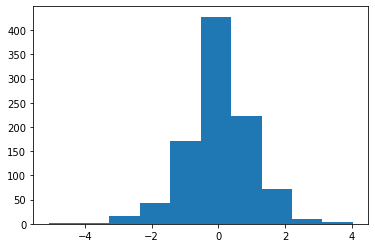

In [84]:
plt.hist(y_train_scaled)

In [85]:
clf = LazyRegressor(predictions=True)
models, predictions = clf.fit(X_train_scaled, X_val_scaled, y_train_scaled, y_val_scaled)
print(models)

100%|██████████| 35/35 [02:25<00:00,  4.16s/it]

                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
LassoLarsIC                                 -0.98       0.00  1.11        0.06
LarsCV                                      -0.99       0.00  1.11        0.83
LassoCV                                     -0.99      -0.00  1.11       10.66
DummyRegressor                              -0.99      -0.00  1.11        0.02
ElasticNet                                  -0.99      -0.00  1.11        0.28
ElasticNetCV                                -0.99      -0.00  1.11        9.28
LassoLarsCV                                 -0.99      -0.00  1.11        0.28
LassoLars                                   -0.99      -0.00  1.11        0.08
Lasso                                       -0.99      -0.00  1.11        0.09
BayesianRidge                               -0.99      -0.00  1.11        0.69
OrthogonalMatchingPursuitCV                 -1.00   

In [87]:
for i in range(predictions.shape[1]):
    print(mean_absolute_error(y_val_scaled, np.array(predictions)[:,i]))

0.8398146651817663
0.8510482339495791
0.8122732470486513
1.1093973485526167
0.8118612291332223
0.8118612291332223
0.8118612291332223
1.1648868996190256
0.8323547761250705
0.8220046471684617
0.8534212261535241
0.8743240605676795
0.8812774326126891
0.8761548755426937
0.812020408379015
0.8118612291332223
0.8118612291332226
0.8118612291332223
0.8118612291332223
0.8104673589005774
0.9080910824643753
0.9211573266317337
1.007138499530551
0.8383298780100021
0.8156545934983607
1.0214445275948263
0.8761548755425577
0.8628725812959259
0.8843869093558315
0.9080910824643753
0.8220046471684617
0.8527121834724305
0.880536402318158


In [86]:
xgb = xgboost.XGBRegressor()
xgb.fit(X_train_scaled, y_train_scaled)
preds = xgb.predict(X_val_scaled)
print(mean_absolute_error(y_val_scaled, preds))

0.8527121834724305


In [ ]:
predictions.to_csv("predictions_test_sin.csv")